# Multi class prediction
We are following up on [part 1](./01_malaria_blood_cells.ipynb).

Most of this notebook is a copy of part 1. But a few things have changed too be able to predict multiple classes.

In this notebook we will introduce:
- one hot encoding
- softmax
- categorical crossentropy

In [2]:

import os

import cv2
import tensorflow as tf
from tomni import bbox_fitting_center
from random import shuffle
from matplotlib import pyplot as plt
import numpy as np 

# This is some code for when you only have 1 GPU in your computer.
# If you have multiple or none it will still work fine
physical_devices = tf.config.list_physical_devices("GPU")
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

N_EPOCHES = 20
IMAGE_DIM = 128

C:\Users\tomni\anaconda3\envs\tf_gpu_2_3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\tomni\anaconda3\envs\tf_gpu_2_3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\tomni\anaconda3\envs\tf_gpu_2_3\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
  stacklevel=1)


## Loading the data

Our malaria data set from part 1 does not have more then 2 classes so we will switch to a different dataset, namely the [Malignant Lymphoma classification dataset](https://www.kaggle.com/andrewmvd/malignant-lymphoma-classification).
I recomment to read the [paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2911652/) for all the details but for us only 1 part is imported, it has 3 different classes to predict.


In [3]:
# Getting all the paths

data_location_cll=r"D:\data\Malignant_Lymphoma\CLL"
data_location_fl=r"D:\data\Malignant_Lymphoma\FL"
data_location_mcl=r"D:\data\Malignant_Lymphoma\MCL"

all_cll_paths = [os.path.join(data_location_cll, i) for i in os.listdir(data_location_cll) if i.endswith(".tif")]
all_fl_paths = [os.path.join(data_location_fl, i) for i in os.listdir(data_location_fl) if i.endswith(".tif")]
all_mcl_paths = [os.path.join(data_location_mcl, i) for i in os.listdir(data_location_mcl) if i.endswith(".tif")]

shuffle(all_cll_paths)
shuffle(all_fl_paths)
shuffle(all_mcl_paths)

In [4]:
def load_and_preprocess(path):
    img = cv2.imread(path)
    img = bbox_fitting_center(img, (IMAGE_DIM, IMAGE_DIM))
    return img

all_cll_images = [load_and_preprocess(path) for path in all_cll_paths[:113]]
all_fl_images = [load_and_preprocess(path) for path in all_fl_paths[:113]]
all_mcl_images = [load_and_preprocess(path) for path in all_mcl_paths[:113]]

## Let's have a look at the data we are dealing with

We will vizualize 96 random images and its labels just to see what we are dealing with.
This is done to give an idea of how things look like, and can help us make descision later on.

In this dataset we can see that cutting out only the middle part of the image make that we loss a lot data. Only if we could do something about it (foreshadowing to random data augmenation).

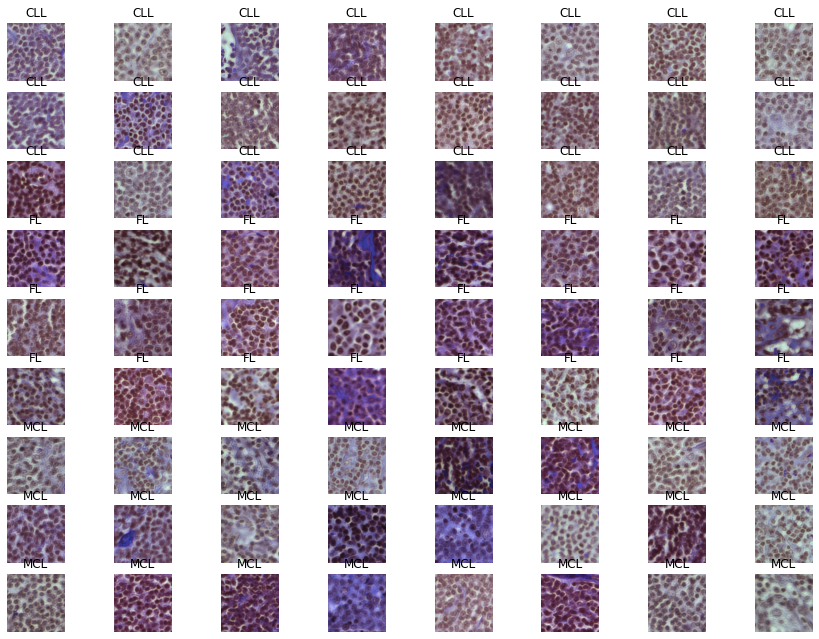

In [5]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(15,15))
for i, image in enumerate(all_cll_images[:24]):
  ax = plt.subplot(12, 8, i + 1)
  plt.imshow(image)
  plt.title("CLL")
  plt.axis("off")

for i, image in enumerate(all_fl_images[:24]):
  ax = plt.subplot(12, 8, i + 25)
  plt.imshow(image)
  plt.title("FL")
  plt.axis("off")

for i, image in enumerate(all_mcl_images[:24]):
  ax = plt.subplot(12, 8, i + 49)
  plt.imshow(image)
  plt.title("MCL")
  plt.axis("off")

plt.show()

## Preparing data for training

The model still only can predict a number, not a class. So once again we assign numbers to our classes. cll becomes 0, fl becomes 1 and mcl becomes 2.

And here is where things become weird. Because if we leave it like this the model will think mcl = 2 * fl. That is, in technical terms, nonesense.
This means that the model will 'think' that if fl signal is very strong it becomes mcl.

Because this is not what we want we will use 1-hot-encoding.
- class 0: `[1, 0, 0]`
- class 1: `[0, 1, 0]`
- class 2: `[0, 0, 1]`

This makes the label 3 numbers long. The model will read a cll label as: it is 100% cll, 0% fl and 0% mcl.
This means the model will not only predict what is the correct label, but also what is NOT the correct label.

To make it even easier, tensorflow already has a function for us to do it!

In [6]:
x = all_cll_images + all_fl_images + all_mcl_images
y = [0] * len(all_cll_images) + [1] * len(all_fl_images) + [2] * len(all_mcl_images)

# we make the numpy arrays because tensorflows doesn't like lists
x = np.array(x)
y = np.array(y)

# We encode the labels and say there are a total of 3 classes
y = tf.one_hot(y, 3)

## Getting the model
We wil use the same model as in part 1 but with 2 changes. We will have it output 3 value instate of 1.
And we changed the activation from sigmoid to softmax.

Softmax look a lot like a sigmoid but has an extra feature, normalize.
It will make sure that the sum of the three classes (CLL, FL, MCL) is always 1 for every image we give it.

Also I remove all the explaination.

In [7]:
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.layers import MaxPooling2D, Conv2D, Flatten
from tensorflow.keras.models import Model

effienct_net_b0 = EfficientNetB0(include_top=False, weights=None, input_shape=(IMAGE_DIM, IMAGE_DIM, 3))
max_pool = MaxPooling2D((4, 4))(effienct_net_b0.output)
conv2d = Conv2D(3, (1, 1), activation="softmax")(max_pool)
flat = Flatten()(conv2d)

input_layer = effienct_net_b0.input
model = Model(input_layer, flat)

In [8]:
test_image = np.array([all_cll_images[0]])

p = model.predict(test_image)

print(p.shape)

(1, 3)


## Loss & optimalization

Now we have our model and data we need 2 more things before we can train our model.

We need a way to determin how well the model does at every given moment.
For this we use the labels and the prediction to calculate 1 number.
The function what does this for us is the loss function.

Secondly we need a way to optimize a model so that every step the loss gets smaller.
This will be our optimizer.

For the loss we will use mean_absolute_error.
This will calculate the average difference between the labels and predictions.

For the optimizer we will use stogastic gradient descent (sgd).
For now it is not very imported to understand them, and there are people who do this way better then I ever can.

Both the optimizer and loss function are standard options in tensorflow.

We will also add a metric for accuracy, just because it is intresting.

In [9]:
model.compile(
    optimizer="sgd", loss="categorical_crossentropy", metrics=['accuracy'])

## Training the model

We have our data, we have our model, we have complied our model with a loss function and optimizer.
So now we can start right?

Yes, we, can!

To train the model we use the fit function.
We give it the data.
And the number of times we want to go throught all the data (epochs).

It will output some history we can plot.

*technical part:*

If this goes really slow check if your GPU is used.
If not, try to fix it or be patient.


In [10]:
history = model.fit(
    x, y, epochs=40
)

Epoch 1/40
11/11 [==============================] - 2s 181ms/step - loss: 6.0186 - accuracy: 0.3923
Epoch 2/40
11/11 [==============================] - 1s 96ms/step - loss: 4.9841 - accuracy: 0.4454
Epoch 3/40
11/11 [==============================] - 1s 96ms/step - loss: 2.2776 - accuracy: 0.5988
Epoch 4/40
11/11 [==============================] - 1s 97ms/step - loss: 2.1864 - accuracy: 0.6254
Epoch 5/40
11/11 [==============================] - 1s 97ms/step - loss: 0.7876 - accuracy: 0.7906
Epoch 6/40
11/11 [==============================] - 1s 97ms/step - loss: 0.5535 - accuracy: 0.8319
Epoch 7/40
11/11 [==============================] - 1s 96ms/step - loss: 0.4517 - accuracy: 0.8938
Epoch 8/40
11/11 [==============================] - 1s 96ms/step - loss: 0.1355 - accuracy: 0.9587
Epoch 9/40
11/11 [==============================] - 1s 97ms/step - loss: 0.1115 - accuracy: 0.9587
Epoch 10/40
11/11 [==============================] - 1s 96ms/step - loss: 0.0681 - accuracy: 0.9764
Epoch 11

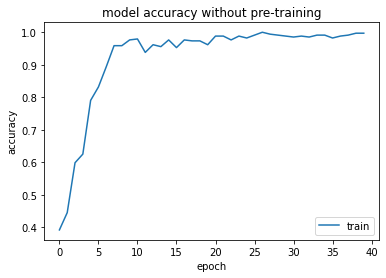

In [11]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.title('model accuracy without pre-training')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

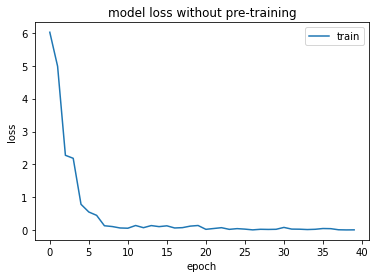

In [12]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss without pre-training')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.legend(['train', 'test'], loc='upper right')
plt.show()

Looking at the plots above we can see that the accuracy goes up and the loss goes down.

That is exactly what we want.

Lets now try this model on a few of a pictures.

footnote:

We use now the same pictures for testing and training, this is not a good idea for the same reason you should not give an exam question to a student before the exam.

We will fix that later.

In [13]:
cll_predictions = model.predict(np.array(all_cll_images[:32]))
fl_predictions = model.predict(np.array(all_fl_images[:32]))
mcl_predictions = model.predict(np.array(all_mcl_images[:32]))

print("CLL",
cll_predictions)

print("FL",
fl_predictions)

print("MCL",
mcl_predictions)

CLL [[9.9917549e-01 4.2742595e-06 8.2023966e-04]
 [9.9983966e-01 2.4975779e-07 1.6007482e-04]
 [9.9999917e-01 9.1034957e-09 8.7957369e-07]
 [9.9602473e-01 3.6458299e-03 3.2936575e-04]
 [9.9972218e-01 2.6476696e-06 2.7522066e-04]
 [9.9995136e-01 1.6757614e-06 4.6974477e-05]
 [9.9999833e-01 4.5134523e-09 1.6155868e-06]
 [9.9999988e-01 1.6125244e-10 9.7038935e-08]
 [9.7792327e-01 2.8131140e-05 2.2048691e-02]
 [9.9999142e-01 8.5098407e-07 7.7474670e-06]
 [9.9999988e-01 7.1317916e-09 8.9496261e-08]
 [9.9999523e-01 5.7978018e-09 4.7099743e-06]
 [9.9990106e-01 1.3411073e-07 9.8787008e-05]
 [9.9970919e-01 2.0802925e-04 8.2687970e-05]
 [9.9994469e-01 1.4477836e-10 5.5268443e-05]
 [9.9999166e-01 3.4155765e-09 8.3650275e-06]
 [9.9992740e-01 1.2092966e-05 6.0588703e-05]
 [9.9993491e-01 2.2455186e-08 6.5141314e-05]
 [9.9992609e-01 7.4180844e-06 6.6456894e-05]
 [9.9914980e-01 1.8864484e-06 8.4825128e-04]
 [9.9990046e-01 9.9330246e-05 1.7917446e-07]
 [9.9986839e-01 5.7542422e-07 1.3101648e-04]
 [9.99

Looking at the results it seems that we have 2 false negatives and that is it.
Not a bad result for our first neural network.

We now have the full flow of training a neural network. Next up we dive deeper into deep learning.

Thank you for you, and tot ziens (Dutch for: see you soon)